# Load and Explore Image Data

In [1]:
import matplotlib.pyplot as plt
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import scipy.io as sio
from numpy import savetxt

In [15]:

# Load data from emnist
data = sio.loadmat("emnist-byclass.mat")['dataset']

X_train = data[0][0][0][0][0][0].reshape(-1, 28, 28)
y_train = data[0][0][0][0][0][1]

X_test = data[0][0][1][0][0][0].reshape(-1, 28, 28)
y_test = data[0][0][1][0][0][1]

# categorical label, convert to one_hot
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

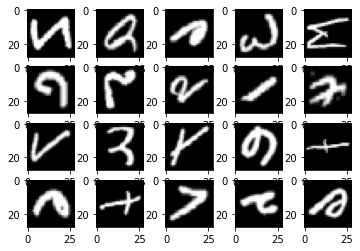

In [3]:
# plot first few images
for i in range(20):
	plt.subplot(4,5,i+1)
	plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

# Specify Training and Validation Sets

In [4]:
from sklearn.model_selection import train_test_split

# Divide the data into 75% training and 25% validation data sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, shuffle=True, random_state=0)

# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Val  : X=%s, y=%s' % (X_val.shape, y_val.shape))
print('Test : X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(523449, 28, 28), y=(523449, 62)
Val  : X=(174483, 28, 28), y=(174483, 62)
Test : X=(116323, 28, 28), y=(116323, 62)


# Define Network Architecture

In [5]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Activation,Dense,Flatten

In [6]:
# NOTE: you can play around with normalization before or after ReLU activation
net = Sequential()
net.add(Conv2D(8, (3, 3), padding='same', input_shape=(28, 28, 1)))
net.add(BatchNormalization())
net.add(Activation('relu'))

net.add(MaxPooling2D((2, 2),strides=2))

net.add(Conv2D(16, (3, 3), padding='same'))
net.add(BatchNormalization())
net.add(Activation('relu'))

net.add(MaxPooling2D((2, 2),strides=2))

net.add(Conv2D(32, (3, 3), padding='same'))
net.add(BatchNormalization())
net.add(Activation('relu'))

net.add(Flatten())
net.add(Dense(62, activation='softmax'))

# Train


In [7]:
from tensorflow.keras.optimizers import SGD

In [9]:
# Hyperparameters
lr = 0.01
mom = 0.9 
ep = 2
bs = 100

In [10]:
# compile and fit the keras model
opt = SGD(learning_rate=lr, momentum=mom)
net.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = net.fit(X_train, y_train, epochs=ep, batch_size=bs, validation_data=(X_val,y_val), verbose=1)

Epoch 1/2
5235/5235 [==============================] - 127s 24ms/step - loss: 0.5417 - accuracy: 0.8201 - val_loss: 0.4496 - val_accuracy: 0.8411
Epoch 2/2
5235/5235 [==============================] - 126s 24ms/step - loss: 0.4193 - accuracy: 0.8507 - val_loss: 0.4085 - val_accuracy: 0.8541


# Test

In [11]:
# You can visualize the results with a confusion matrix.
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
def plot_confusion_matrix(y_classified, y_true):
  # Compute confusion matrix
  c_mat = np.zeros((y_test.shape[1],y_test.shape[1]))
  for i in range(len(y_true)):
    c_mat[y_classified[i], y_true[i] ] += 1

  group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
  labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.asarray(labels).reshape(c_mat.shape[0], c_mat.shape[1])

  plt.figure(figsize=(12,10))
  sn.heatmap(c_mat, annot=labels, cmap='rocket_r')
  #  sn.heatmap(c_mat, annot=labels, fmt='', cmap='rocket_r')
  plt.title("Confusion Matrix")
  plt.ylabel('Output Class')
  plt.xlabel('Target Class')

In [12]:
from sklearn.metrics import confusion_matrix

# Evaluate the trained model using keras built-in function
score = net.evaluate(X_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1]) 

3636/3636 [==============================] - 16s 4ms/step - loss: 0.4091 - accuracy: 0.8537
Test loss: 0.40914851427078247
Test accuracy: 0.8537262678146362


In [13]:
y_classified = np.argmax(net.predict(X_test), axis=1)
y_pred =  np.argmax(y_test, axis=1)

3636/3636 [==============================] - 17s 5ms/step


In [16]:
savetxt('ypred_CNN.csv', y_pred, delimiter=',')
print(y_pred.shape)

(116323,)


In [17]:
cm = confusion_matrix(y_pred, y_classified)

correct = 0
for i in range(len(cm)):
    correct += cm[i][i]

r = round((correct) / np.sum(cm), 4)
print(f'Classifiation Rate: {r}')

from numpy import savetxt
savetxt('data_CNN.csv', cm, delimiter=',')

Classifiation Rate: 0.8537
